In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import time
from IPython import display
import sys

In [2]:
#constants
# PHYSICAL PARAMETERS

Mj      = 8.93e22 #  kg      Io mass
Rj      = 1.82e6 #  m      Io radius
G       = 6.67e-11 #  Gravitational constant in SI units

# SIMULATION PARAMETERS
Ninit   = 2000 # Number of particles (if new object is created)
m       = Mj/Ninit # SPH particle mass 
dt      = 50 # Time step size
ball_size = Rj / (np.cbrt(Ninit) * np.sqrt(2))
print(ball_size)


102144.04639615293


In [3]:
def init_IO(n):
    
    init_state = [np.zeros([6])]
    
    while len(init_state) < n:
        tmp_state = np.zeros([6])
        tmp_state[:3] = (np.random.rand(3) - 0.5) * Rj * 2
        
        vec = (tmp_state - init_state)
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * 1.05:
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            continue
            
        init_state.append(tmp_state)
        
    
    return np.array(init_state)

def init_comet(state, moon_ratio=0.1):
    
    state = list(state)
    state.append([5e7, 0, 0, -5e5, 0, 0])

    while len(state) < int(Ninit + Ninit * moon_ratio):

        tmp_state = [5e7, 0, 0, -5e5, 0, 0]
        tmp_state[:3] += (np.random.randn(3) - 0.5) * Rj #* 6 * moon_ratio
        
        vec = (tmp_state - np.array(state)[Ninit:])
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * moon_ratio * 5:
            #print('too far away')
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            #print('too close to other ball')
            continue
            
        state.append(tmp_state)
        
    return np.array(state)



def new_state(state, Fi, distances):
    
    if any(np.where((distances < 2 * ball_size) & (distances > 0))[0]):

        updates = np.where((distances < 2 * ball_size) & (distances > 0))
        to_be_updated = updates[0]
        updated_with = updates[1]
        state_updates = state[updated_with]        

        for i in range(0,len(to_be_updated)):
            #state[to_be_updated[i]][3:] = state_updates[i] * 0.999
            state[to_be_updated[i]], s = collision(state[to_be_updated[i]], state_updates[i], 0.999)
    
    a = Fi / m
    
    state[:,3:] += a * dt
    state[:,0:3] += state[:,3:]
    
    return state

    
    
def gravity_n_body(state):
    
    Fi = []
    distances = []

    for i in range(0, len(state)):
        
        vec = (state[i] - state)#np.delete(state, i, axis=0))
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        distances.append(distance)
        #print(vec)
        #print((vec.transpose()/distance**3).transpose())
        Fi.append(np.sum(- G * m ** 2 * np.nan_to_num(vec.transpose()/distance**3).transpose(), axis = 0))
        
    return np.array(Fi), np.array(distances)


def collision(state1, state2, inelasticity=1):
    """
    tmp_state = np.array([state1[3:], state2[3:]])

    state1[3:] = tmp_state[1] * inelasticity
    state2[3:] = tmp_state[0] * inelasticity

    """
    state_diff = state1[0:3] - state2[0:3]
    #print(state_diff)
    n = np.nan_to_num(state_diff / len_vec(state_diff))
    #print(n, len_vec(n))
    
    v_rel = state1[3:] - state2[3:]
    #print(v_rel)
    v_norm = np.dot(v_rel, n) * n
    #print(v_norm)
    
    state1[3:] = (state1[3:] - v_norm) * inelasticity
    state2[3:] = (state2[3:] + v_norm) * inelasticity
    
    return state1, state2


    
def len_vec(vec):
    
    return np.sqrt(np.sum([i ** 2 for i in vec]))
    


In [4]:
# test collision

state = init_IO(n=Ninit)

#state = np.array([[-1.,1.,-2.,1.,-3.,1.], [2.,3.,2.,-1.,2.,-1.]])
#state = np.array([np.random.randn(6), np.random.randn(6)])
print(len_vec(abs(state[0][3:]) + abs(state[1][3:])))


print(abs(state[0][3:]) + abs(state[1][3:]))

state = collision(state[0], state[1])

print(state)
print(abs(state[0][3:]) + abs(state[1][3:]))
print(len_vec(abs(state[0][3:]) + abs(state[1][3:])))

0.0
[0. 0. 0.]
(array([0., 0., 0., 0., 0., 0.]), array([ -586909.03488237,  -521660.57994096, -1626112.58811544,
              0.        ,        0.        ,        0.        ]))
[0. 0. 0.]
0.0


In [5]:
# generate IO and comet

start_state = init_IO(n=Ninit)
print('done generating IO')
start_state = init_comet(start_state)
print('done generating comet')


done generating IO
done generating comet


In [6]:
# create plot states

N = 200 # animation frames
state = start_state
states = []
for i in range(0,N):
    #print(state)
    Fi, distances = gravity_n_body(state)

    state = new_state(state, Fi, distances)
    #print(state, '\n')
    states.append(np.array(state))
    #print(states)
    #print('--------------')

C:\Users\mikkel\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


In [7]:
#generate distances

distances = []

for i in range(0,len(states[0])):
    vec = (states[0][i] - states[0])#np.delete(state, i, axis=0))
    vec = vec[:,0:3]
    distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
    distances.append(distance[0])
    

colors = distances
colors[Ninit:] = np.zeros([len(distances[Ninit:])])


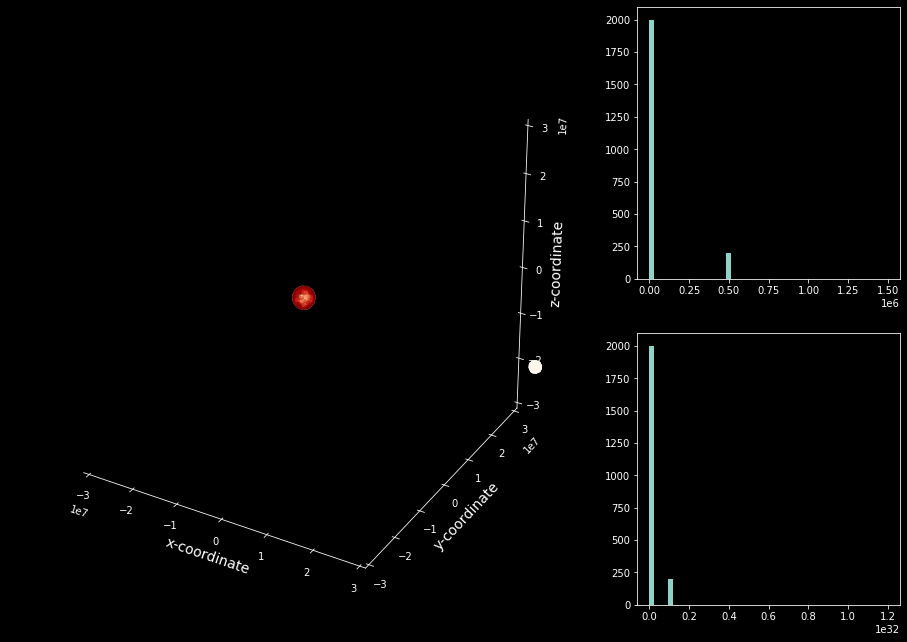

In [8]:
# for plot testing

import matplotlib.gridspec as gridspec
plt.style.use('dark_background')
# test init plot
zoom = 1e7
fig = plt.figure(figsize=(16,11))
# set up subplot grid
gridspec.GridSpec(3,3)
plt.set_cmap('OrRd')

# large subplot
ax = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2, projection='3d')
scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000)#, c=distances)

# small subplot 1
ax2 = plt.subplot2grid((2,3), (0,2))
vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.5e6,51))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# small subplot 2
plt.subplot2grid((2,3), (1,2))
plt.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))

# small subplot 3
#plt.subplot2grid((3,3), (2,2))
#plt.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))

#
#ax.view_init(elev=90, azim=0) # view x-y
#ax.view_init(elev=0, azim=0) # view y-z
#ax.view_init(elev=0, azim=90) # view x-z

scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)

    
#ax.view_init(elev=90, azim=0)
#ax.plot_surface(img_x * 5, img_y * 5, img_z, rstride=10, cstride=10, facecolors=img)
#scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)



# Setting the axes properties
ax.set_xlim3d(-3*zoom, 3*zoom)
ax.set_ylim3d(-3*zoom, 3*zoom)
ax.set_zlim3d(-3*zoom, 3*zoom)

ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


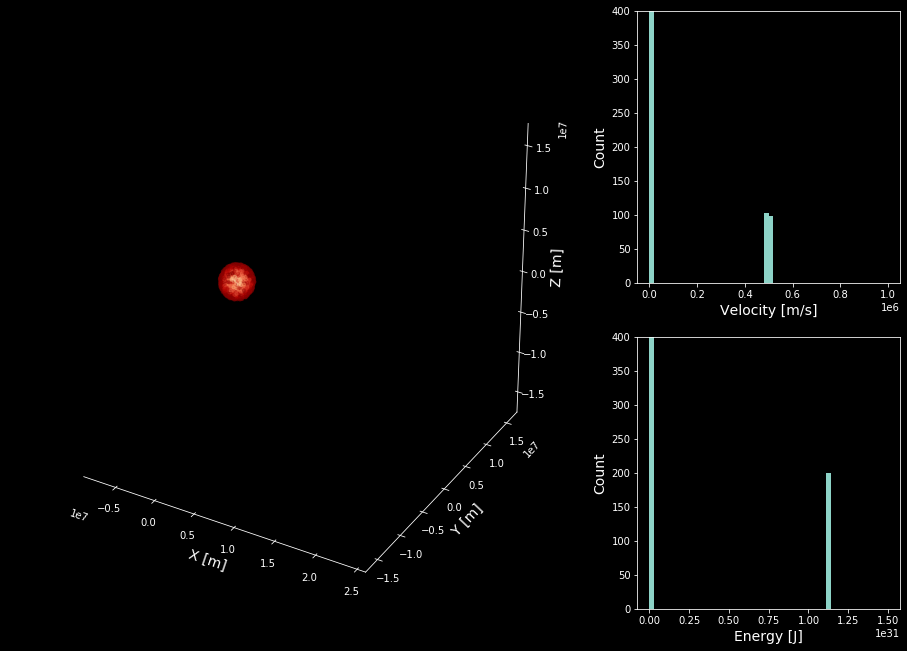

Wall time: 1min 30s


In [9]:
%%time
# Generate the animation

plt.style.use('dark_background')
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import matplotlib.gridspec as gridspec


# test init plot
fig = plt.figure(figsize=(16,11))
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2, projection='3d')
scatters = ax1.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances, cmap='OrRd')

# small subplot 1
ax2 = plt.subplot2grid((2,3), (0,2))
vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1e6,51))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# small subplot 2
ax3 = plt.subplot2grid((2,3), (1,2))
e_hist = ax3.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.5e31,51))



def update(states):
    
    # update 3d plot
    scatters._offsets3d = (states[:,0], states[:,1], states[:,2])
    
    # update histograms
    ax2.cla()
    ax2.set_ylim(0,Ninit/5)
    vel_hist = ax2.hist(np.sqrt(states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2), bins=np.linspace(0,1e6,51))
    ax2.set_xlabel("Velocity [m/s]",fontsize=14)
    ax2.set_ylabel("Count",fontsize=14)
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax3.cla()
    ax3.set_ylim(0,Ninit/5)
    e_hist = ax3.hist(m * (states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2), bins=np.linspace(0,1.5e31,51))
    ax3.set_xlabel("Energy [J]",fontsize=14)
    ax3.set_ylabel("Count",fontsize=14)

    return scatters


fn = get_sample_data(r'C:\Users\mikkel\Desktop\planet_sim\jupiterlarge.png', asfileobj=False)
img = read_png(fn)

zoom = 1e7

# for background image, renders really slow
x, y = ogrid[0:img.shape[0], 0:img.shape[1]]
scaling = zoom / img.shape[0]
x_y_fac = x[-1] / y[0][-1]

img_x = x * scaling - (0.5 * max(x * scaling))
img_y = y * scaling - (0.5 * y[0][-1] * scaling)
img_z = np.zeros([img.shape[0], img.shape[1]]) - zoom

    
#ax.view_init(elev=90, azim=0)
#ax.plot_surface(img_x * 5, img_y * 5, img_z, rstride=10, cstride=10, facecolors=img)
#scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)


# Setting the axes properties
ax1.set_xlim3d(-1.5*zoom*x_y_fac, 4.5*zoom*x_y_fac)
ax1.set_ylim3d(-3*zoom*x_y_fac, 3*zoom*x_y_fac)
ax1.set_zlim3d(-3*zoom*x_y_fac, 3*zoom*x_y_fac)

ax1.set_xlabel("X [m]",fontsize=14)
ax1.set_ylabel("Y [m]",fontsize=14)
ax1.set_zlabel("Z [m]",fontsize=14)

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax2.set_ylim(0,Ninit/5)
ax2.set_xlabel("Velocity [m/s]",fontsize=14)
ax2.set_ylabel("Count",fontsize=14)
ax2.ticklabel_format(style='sci')

ax3.set_ylim(0,Ninit/5)
ax3.set_xlabel("Energy [J]",fontsize=14)
ax3.set_ylabel("Count",fontsize=14)


ani = animation.FuncAnimation(fig, update, states, interval=100, blit=False)
ani.save('matplot003.gif', writer='imagemagick')
plt.show()